In [8]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg
from analysis import plot as analysis_plot
import scipy as sp
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from sklearn.base import clone
import seaborn as sns
import pickle
from scipy.stats import multivariate_normal
# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
from sklearn.metrics import silhouette_score

%matplotlib inline

Fit progressively more GMM components to an EMG dataset to see where there are diminishing returns.

In [9]:
mean_rewards = np.load("subject_rewards.npy")
mean_rewards.shape

(46,)

In [10]:
with open('olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
len(subjects)

46

In [4]:
subject_calibration_stacks = np.load("subject_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

subject_raw_calibration_stacks = np.load("subject_raw_calibration_stacks.npy")
print(subject_raw_calibration_stacks.shape)

# subject_movement_stacks = np.load("subject_movement_stacks.npy")
# print(subject_movement_stacks.shape)

(46, 2, 32, 64, 1000)
(46, 2, 32, 64, 1000)
(46, 45, 12, 64, 2000)


In [11]:
highest_subject = np.argmax(mean_rewards)
median_subject = np.argsort(mean_rewards)[len(mean_rewards)//2]
lowest_subject = np.argmin(mean_rewards)

In [12]:
MAX_COMPONENTS = 13

In [13]:
def fit_mixture_models(data,components):
    assert len(data.shape) == 2
    assert data.shape[1] == 64
    assert data.shape[0] > data.shape[1]
    models = []
    for num_components in components:
        print(f"Fitting {num_components} components")
        model = BayesianGaussianMixture(n_components=num_components,
                                        weight_concentration_prior_type='dirichlet_process',
                                        weight_concentration_prior=1.e-8,
                                        max_iter=200,
                                        n_init=1,
                                        warm_start=True,
                                        random_state=0,
                                        )
        model.fit(data) 
        models.append(model)
        model = clone(model)
    return models

def compute_silhouette_scores(models,data):
    assert len(data.shape) == 2
    assert data.shape[1] == 64
    assert data.shape[0] > data.shape[1]
    silhouette_scores = []
    for model in models:
        silhouette_scores += [silhouette_score(data, model.predict(data))]
    return silhouette_scores

### test

Fitting 1 components
Fitting 2 components
Fitting 3 components
Fitting 4 components
Fitting 5 components
Fitting 6 components
Fitting 7 components
Fitting 8 components
Fitting 9 components
Fitting 10 components
Fitting 11 components
Fitting 12 components


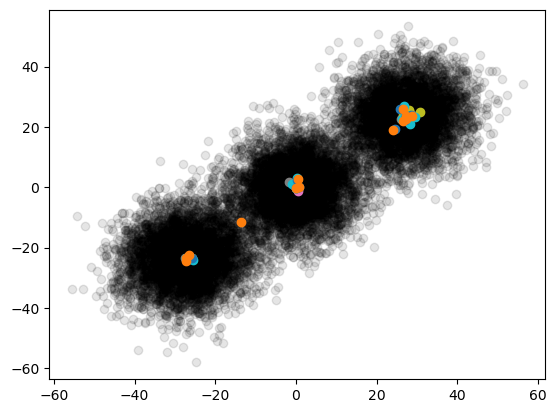

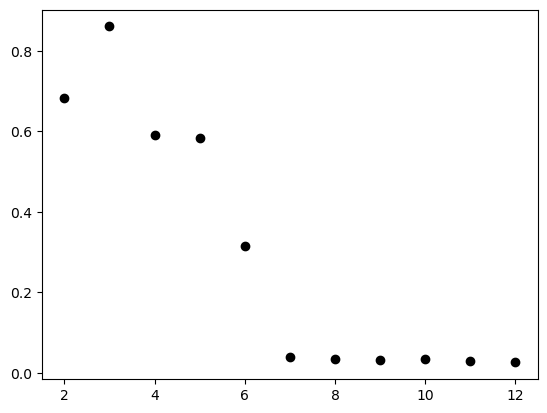

In [7]:
gaussians = [np.random.multivariate_normal(np.zeros(shape=(64,)),cov=np.eye(64),size=5000),
             np.random.multivariate_normal(10*np.ones(shape=(64,)),cov=np.eye(64),size=5000),
             np.random.multivariate_normal(-10*np.ones(shape=(64,)),cov=np.eye(64),size=5000)]
samples = np.row_stack(gaussians)

# 64 -> 2 decoder
d = np.random.normal(0,1,(2,64))

for i,g in enumerate(gaussians):
    s = d @ g.T
    plt.plot(s[0],s[1],'ko',alpha=0.1)

models = fit_mixture_models(samples,range(1,MAX_COMPONENTS))

for model in models:
    means = [d @ mean_ for mean_ in model.means_]
    plt.plot([m[0] for m in means],[m[1] for m in means],'o')

silhouette_scores = compute_silhouette_scores(models[1:], samples)

plt.figure()
plt.plot(range(2,len(models)+1),silhouette_scores,"ko")

# calibration data

### highest reward subject

In [66]:
high_data = subject_calibration_stacks[highest_subject].transpose((0,1,3,2)).reshape(-1,64)
high_data = analysis.remove_nan_rows(high_data)

models = fit_mixture_models(high_data,range(1,MAX_COMPONENTS))
silhouette_scores = compute_silhouette_scores(models[1:], high_data)

# 

log_high_data = np.log(high_data)
print(f"{len(np.where(np.isnan(log_high_data))[0])} NaNs")
log_high_data = analysis.remove_nan_rows(log_high_data)

log_models = fit_mixture_models(log_high_data,range(1,MAX_COMPONENTS))
log_silhouette_scores = compute_silhouette_scores(log_models[1:], log_high_data)

Fitting 1 components
Fitting 2 components
Fitting 3 components
Fitting 4 components
Fitting 5 components
Fitting 6 components
Fitting 7 components
Fitting 8 components
Fitting 9 components


/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_3240/3515641284.py:9: RuntimeWarning: invalid value encountered in log
  log_high_data = np.log(high_data)


74 NaNs
Fitting 1 components
Fitting 2 components
Fitting 3 components
Fitting 4 components
Fitting 5 components
Fitting 6 components
Fitting 7 components
Fitting 8 components
Fitting 9 components


In [68]:
# with open("calibration_elbow_models_highest.pkl","wb") as handle:
#     pickle.dump(models,handle)

# with open("calibration_elbow_log_models_highest.pkl","wb") as handle:
#     pickle.dump(log_models,handle)

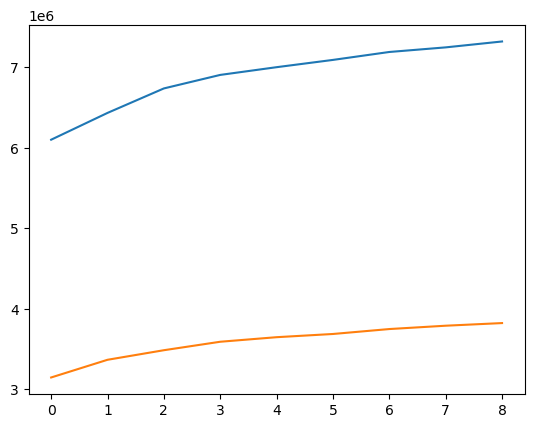

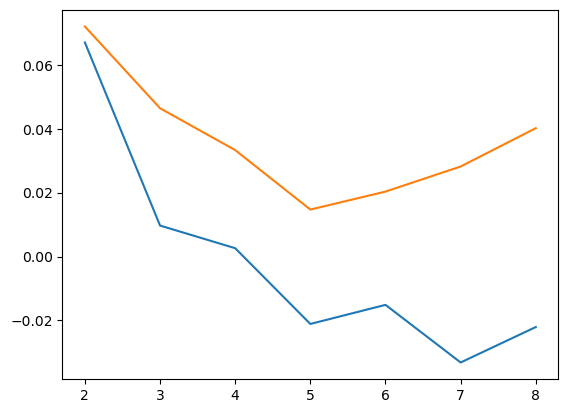

In [73]:
plt.figure()
plt.plot([model.lower_bound_ for model in models],label="Lognormal")
plt.plot([model.lower_bound_ for model in log_models],label="Normal")

plt.figure()
plt.plot(range(2,9),silhouette_scores[1:],label="Lognormal")
plt.plot(range(2,9),log_silhouette_scores[1:],label="Normal")

### median

In [86]:
median_data = subject_calibration_stacks[median_subject].transpose((0,1,3,2)).reshape(-1,64)
median_data = analysis.remove_nan_rows(median_data)

models = fit_mixture_models(median_data,range(1,MAX_COMPONENTS))

# 

log_median_data = np.log(median_data)
print(f"{len(np.where(np.isnan(log_median_data))[0])} NaNs")
log_median_data = analysis.remove_nan_rows(log_median_data)

log_models = fit_mixture_models(log_median_data,range(1,MAX_COMPONENTS))

Fitting 1 components
Fitting 2 components


KeyboardInterrupt: 

In [78]:
# with open("calibration_elbow_models_median.pkl","wb") as handle:
#     pickle.dump(models,handle)

# with open("calibration_elbow_log_models_median.pkl","wb") as handle:
#     pickle.dump(log_models,handle)

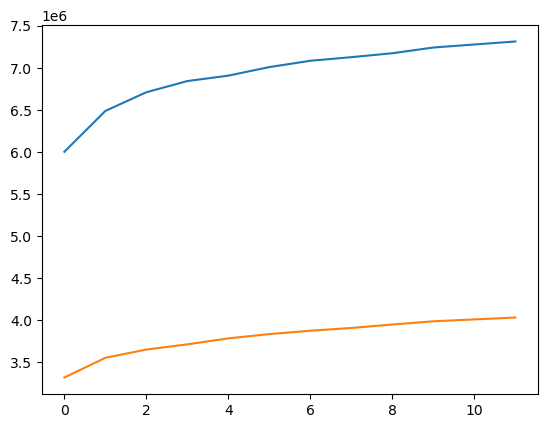

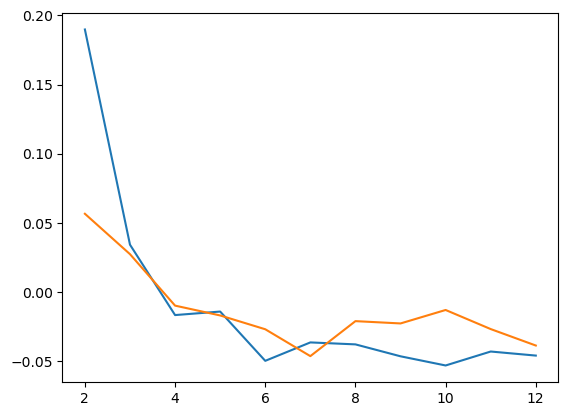

In [88]:
plt.figure()
plt.plot([model.lower_bound_ for model in models],label="Lognormal")
plt.plot([model.lower_bound_ for model in log_models],label="Normal")

silhouette_scores = compute_silhouette_scores(models[1:], median_data)
log_silhouette_scores = compute_silhouette_scores(log_models[1:], log_median_data)

plt.figure()
plt.plot(range(2,MAX_COMPONENTS),silhouette_scores,label="Lognormal")
plt.plot(range(2,MAX_COMPONENTS),log_silhouette_scores,label="Normal")

### low

In [ ]:
low_data = subject_calibration_stacks[lowest_subject].transpose((0,1,3,2)).reshape(-1,64)
low_data = analysis.remove_nan_rows(low_data)

models = fit_mixture_models(low_data,range(1,10))
silhouette_scores = compute_silhouette_scores(models[1:], low_data)

# 

log_low_data = np.log(low_data)
print(f"{len(np.where(np.isnan(log_low_data))[0])} NaNs")
log_low_data = analysis.remove_nan_rows(log_low_data)

log_models = fit_mixture_models(log_low_data,range(1,10))
log_silhouette_scores = compute_silhouette_scores(log_models[1:], log_low_data)

In [ ]:
# with open("calibration_elbow_models_lowest.pkl","wb") as handle:
#     pickle.dump(models,handle)

# with open("calibration_elbow_log_models_lowest.pkl","wb") as handle:
#     pickle.dump(log_models,handle)

## load models

In [43]:
with open("calibration_elbow_models_highest.pkl","rb") as handle:
    models = pickle.load(handle)

with open("calibration_elbow_log_models_highest.pkl","rb") as handle:
    log_models = pickle.load(handle)

In [87]:
with open("calibration_elbow_models_median.pkl","rb") as handle:
    models = pickle.load(handle)

with open("calibration_elbow_log_models_median.pkl","rb") as handle:
    log_models = pickle.load(handle)

In [ ]:
with open("calibration_elbow_models_lowest.pkl","rb") as handle:
    models = pickle.load(handle)

with open("calibration_elbow_log_models_lowest.pkl","rb") as handle:
    log_models = pickle.load(handle)

# trial data

### highest

In [35]:
def log_emg_data(samples):
    print(samples.shape)
    samples[:,56] = np.mean(samples[:,(56-8,56-16)],axis=1)
    print(samples.shape)
    return np.log(samples)

In [36]:
stack = np.load(f"filtered_stacks/filtered_stack_{highest_subject}.npy")
samples = stack.transpose((0,1,3,2)).reshape(-1,64)
log_emg_data(samples)

(1080000, 64)
(1080000, 64)


array([[-1.63257721, -1.54491634, -2.05308664, ..., -3.04916469,
        -2.14751266, -2.39524444],
       [-1.63786637, -1.54929786, -2.06088135, ..., -3.02225815,
        -2.11374344, -2.37143252],
       [-1.64222769, -1.55310143, -2.06781296, ..., -3.00012282,
        -2.08640022, -2.35071698],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

(45, 12, 64, 2000)
(100546, 64)
(100546, 64)
0 NaNs
(100546, 64)


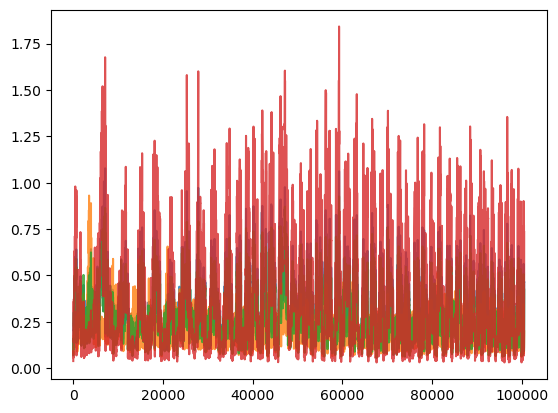

In [26]:
stack = np.load(f"filtered_stacks/filtered_stack_{highest_subject}.npy")
print(stack.shape)
high_data = stack.transpose((0,1,3,2)).reshape(-1,64)
high_data = analysis.remove_nan_rows(high_data)
print(high_data.shape)

# fix the channel 56 problem
high_data[:,56] = np.mean(high_data[:,(56-8,56-16)],axis=1)
print(high_data.shape)

for ch in [56-8,55,56,57]:
    channel = high_data[:,ch]
    plt.plot(channel,alpha=0.8)
    # plt.plot(np.argwhere(channel <= 0),channel[channel <= 0],"ro")

log_high_data = np.log(high_data)
print(f"{len(np.where(np.isnan(log_high_data))[0])} NaNs")
log_high_data = analysis.remove_nan_rows(log_high_data)
print(log_high_data.shape)

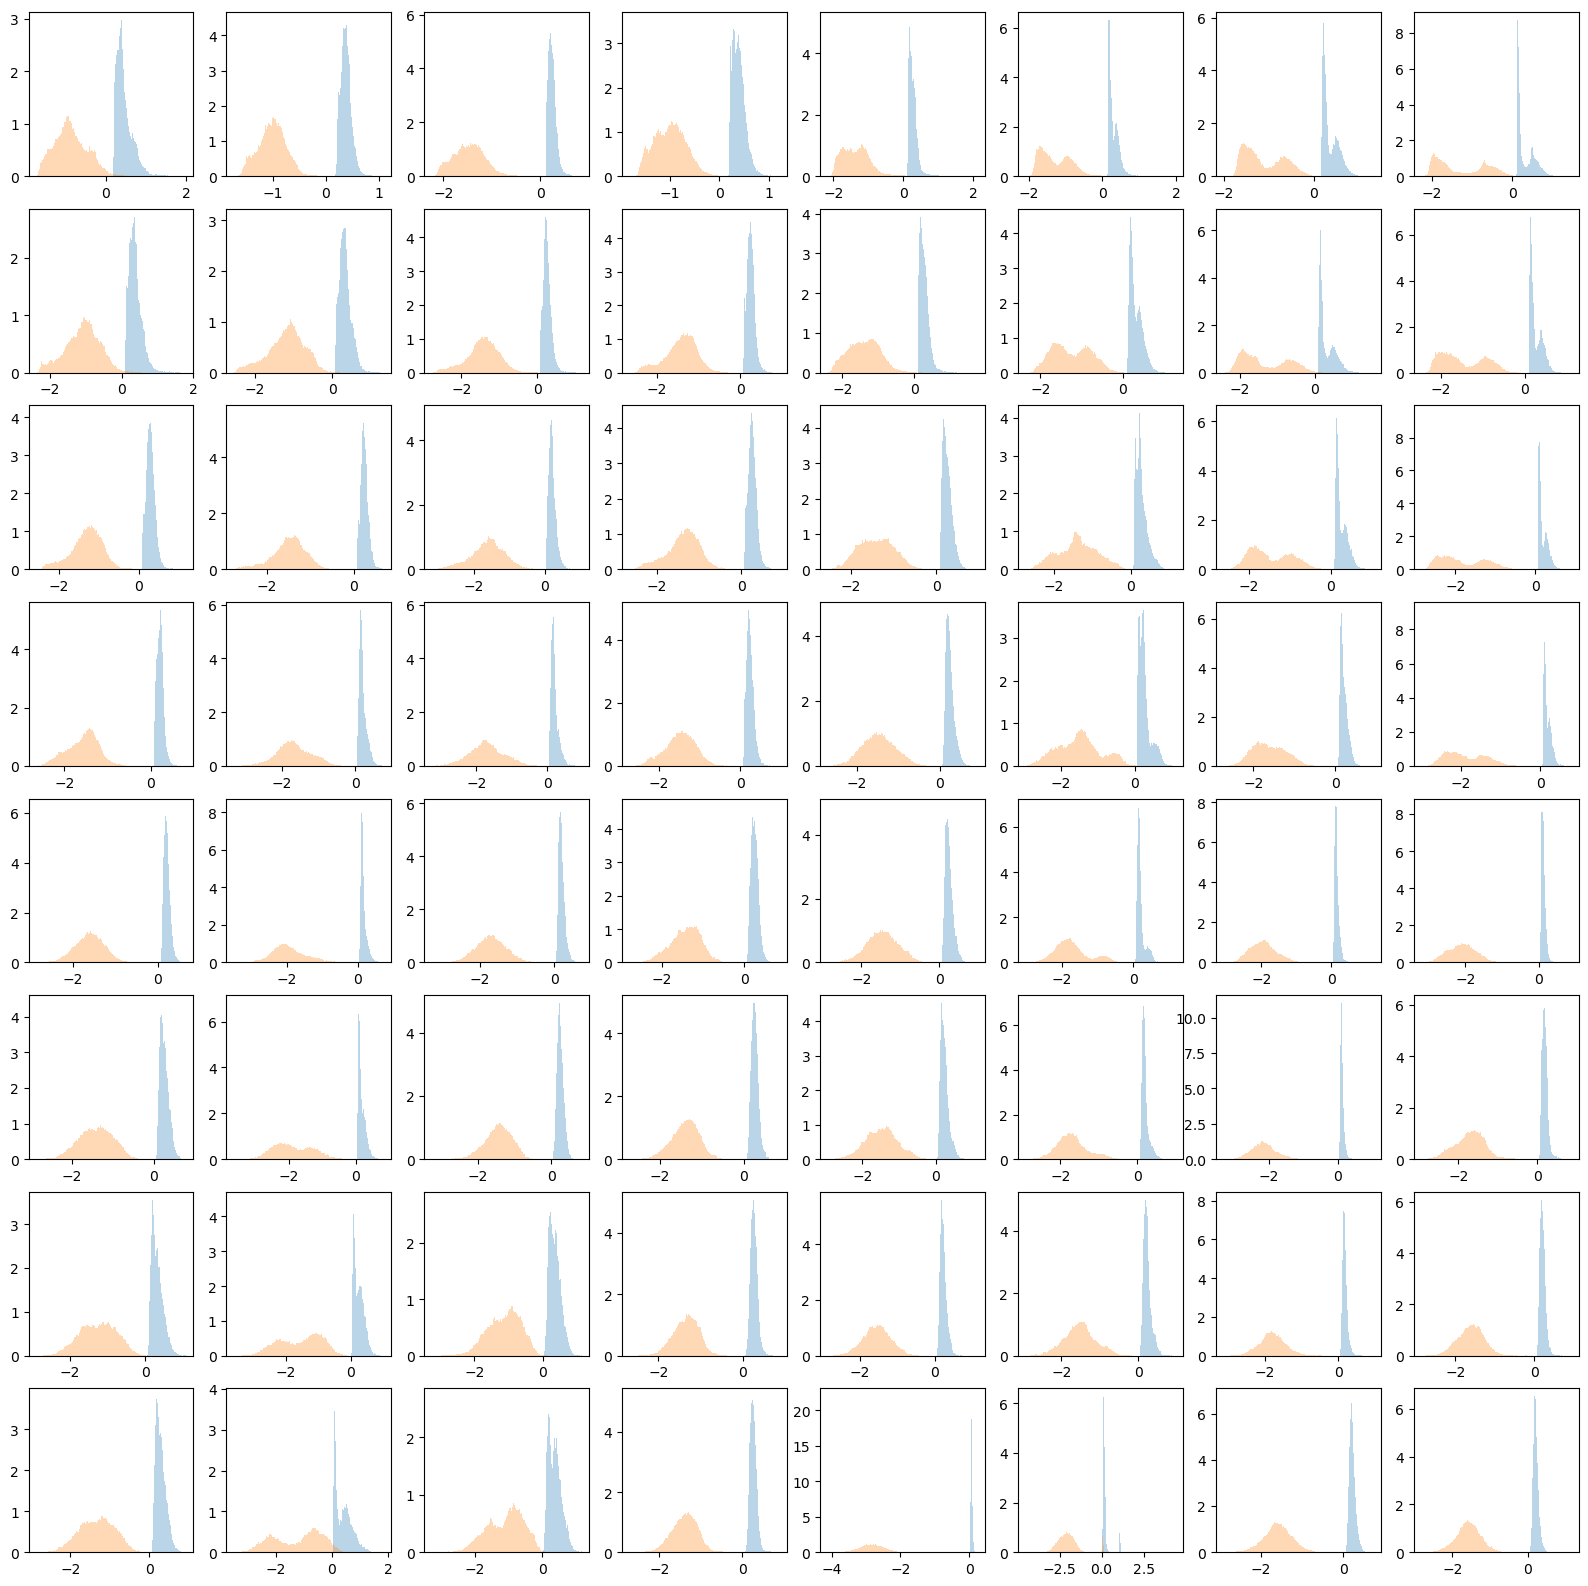

In [29]:
fig, axes = plt.subplots(8,8,figsize=(20,20))
axes = axes.ravel()
for i, ax in enumerate(axes):
    _ = ax.hist(high_data[:,i],bins=100,alpha=0.3,density=True)
    _ = ax.hist(log_high_data[:,i],bins=100,alpha=0.3,density=True)

In [30]:
models = fit_mixture_models(high_data,range(1,MAX_COMPONENTS))
silhouette_scores = compute_silhouette_scores(models[1:], high_data)

log_models = fit_mixture_models(log_high_data,range(1,MAX_COMPONENTS))
log_silhouette_scores = compute_silhouette_scores(log_models[1:], log_high_data)

Fitting 1 components
Fitting 2 components
Fitting 3 components
Fitting 4 components
Fitting 5 components
Fitting 6 components
Fitting 7 components
Fitting 8 components
Fitting 9 components
Fitting 10 components
Fitting 11 components
Fitting 12 components
Fitting 1 components
Fitting 2 components
Fitting 3 components
Fitting 4 components
Fitting 5 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 6 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 7 components
Fitting 8 components
Fitting 9 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 10 components
Fitting 11 components
Fitting 12 components


In [31]:
with open("trial_elbow_models_highest.pkl","wb") as handle:
    pickle.dump(models,handle)

with open("trial_elbow_log_models_highest.pkl","wb") as handle:
    pickle.dump(log_models,handle)

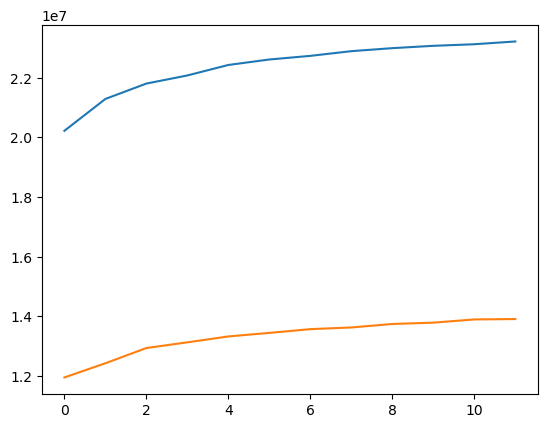

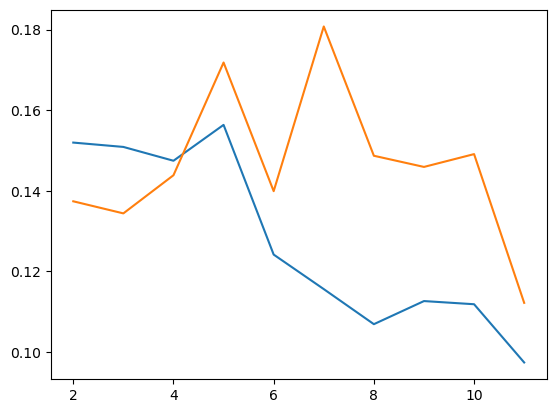

In [32]:
plt.figure()
plt.plot(range(len(models)),[model.lower_bound_ for model in models],label="Lognormal")
plt.plot(range(len(log_models)),[model.lower_bound_ for model in log_models],label="Normal")

plt.figure()
plt.plot(range(2,len(silhouette_scores)+1),silhouette_scores[1:],label="Lognormal")
plt.plot(range(2,len(log_silhouette_scores)+1),log_silhouette_scores[1:],label="Normal")

### median

(45, 12, 64, 2000)
(145300, 64)
(145300, 64)
0 NaNs
(145300, 64)


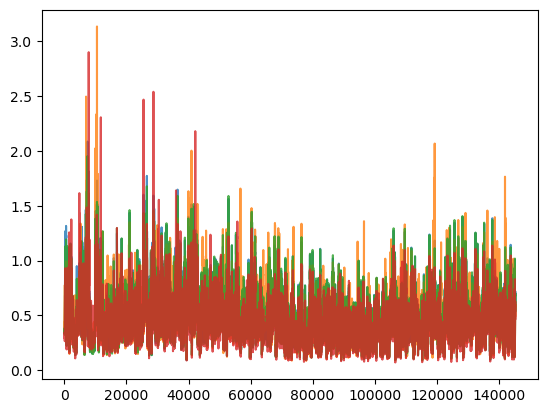

In [33]:
stack = np.load(f"filtered_stacks/filtered_stack_{median_subject}.npy")
print(stack.shape)
median_data = stack.transpose((0,1,3,2)).reshape(-1,64)
median_data = analysis.remove_nan_rows(median_data)
print(median_data.shape)

# fix the channel 56 problem
median_data[:,56] = np.mean(median_data[:,(56-8,56-16)],axis=1)
print(median_data.shape)

for ch in [56-8,55,56,57]:
    channel = median_data[:,ch]
    plt.plot(channel,alpha=0.8)
    # plt.plot(np.argwhere(channel <= 0),channel[channel <= 0],"ro")

log_median_data = np.log(median_data)
print(f"{len(np.where(np.isnan(log_median_data))[0])} NaNs")
log_median_data = analysis.remove_nan_rows(log_median_data)
print(log_median_data.shape)

In [34]:
models = fit_mixture_models(median_data,range(1,MAX_COMPONENTS))
silhouette_scores = compute_silhouette_scores(models[1:], median_data)

log_models = fit_mixture_models(log_median_data,range(1,MAX_COMPONENTS))
log_silhouette_scores = compute_silhouette_scores(log_models[1:], log_median_data)

Fitting 1 components
Fitting 2 components
Fitting 3 components
Fitting 4 components
Fitting 5 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 6 components
Fitting 7 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 8 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 9 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 10 components
Fitting 11 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 12 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 1 components
Fitting 2 components
Fitting 3 components
Fitting 4 components
Fitting 5 components
Fitting 6 components
Fitting 7 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 8 components
Fitting 9 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 10 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 11 components
Fitting 12 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [37]:
with open("trial_elbow_models_median.pkl","wb") as handle:
    pickle.dump(models,handle)

with open("trial_elbow_log_models_median.pkl","wb") as handle:
    pickle.dump(log_models,handle)

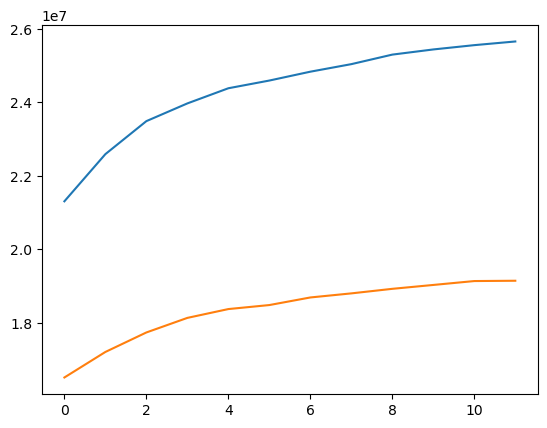

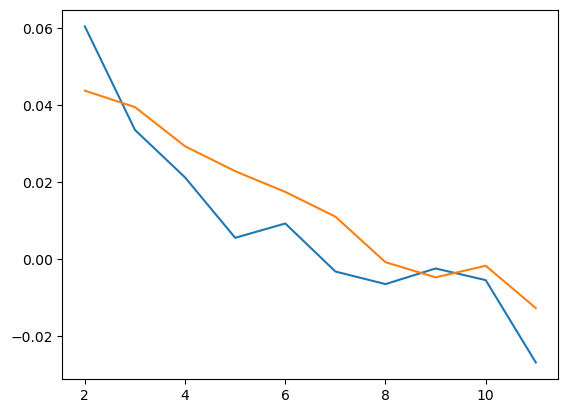

In [38]:
plt.figure()
plt.plot(range(len(models)),[model.lower_bound_ for model in models],label="Lognormal")
plt.plot(range(len(log_models)),[model.lower_bound_ for model in log_models],label="Normal")

plt.figure()
plt.plot(range(2,len(silhouette_scores)+1),silhouette_scores[1:],label="Lognormal")
plt.plot(range(2,len(log_silhouette_scores)+1),log_silhouette_scores[1:],label="Normal")

## lowest

(45, 12, 64, 2000)
(195240, 64)
(195240, 64)
0 NaNs
(195240, 64)


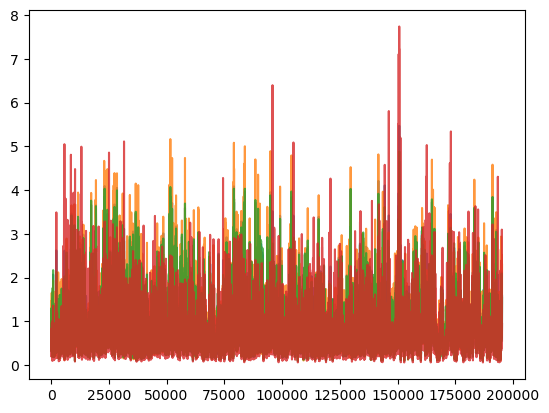

In [39]:
stack = np.load(f"filtered_stacks/filtered_stack_{lowest_subject}.npy")
print(stack.shape)
lowest_data = stack.transpose((0,1,3,2)).reshape(-1,64)
lowest_data = analysis.remove_nan_rows(lowest_data)
print(lowest_data.shape)

# fix the channel 56 problem
lowest_data[:,56] = np.mean(lowest_data[:,(56-8,56-16)],axis=1)
print(lowest_data.shape)

for ch in [56-8,55,56,57]:
    channel = lowest_data[:,ch]
    plt.plot(channel,alpha=0.8)
    # plt.plot(np.argwhere(channel <= 0),channel[channel <= 0],"ro")

log_lowest_data = np.log(lowest_data)
print(f"{len(np.where(np.isnan(log_lowest_data))[0])} NaNs")
log_lowest_data = analysis.remove_nan_rows(log_lowest_data)
print(log_lowest_data.shape)

In [40]:
models = fit_mixture_models(lowest_data,range(1,MAX_COMPONENTS))
silhouette_scores = compute_silhouette_scores(models[1:], lowest_data)

log_models = fit_mixture_models(log_lowest_data,range(1,MAX_COMPONENTS))
log_silhouette_scores = compute_silhouette_scores(log_models[1:], log_lowest_data)

Fitting 1 components
Fitting 2 components
Fitting 3 components
Fitting 4 components
Fitting 5 components
Fitting 6 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 7 components
Fitting 8 components
Fitting 9 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 10 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 11 components
Fitting 12 components
Fitting 1 components
Fitting 2 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 3 components
Fitting 4 components
Fitting 5 components
Fitting 6 components
Fitting 7 components
Fitting 8 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 9 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 10 components
Fitting 11 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Fitting 12 components


/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [41]:
with open("trial_elbow_models_lowest.pkl","wb") as handle:
    pickle.dump(models,handle)

with open("trial_elbow_log_models_lowest.pkl","wb") as handle:
    pickle.dump(log_models,handle)

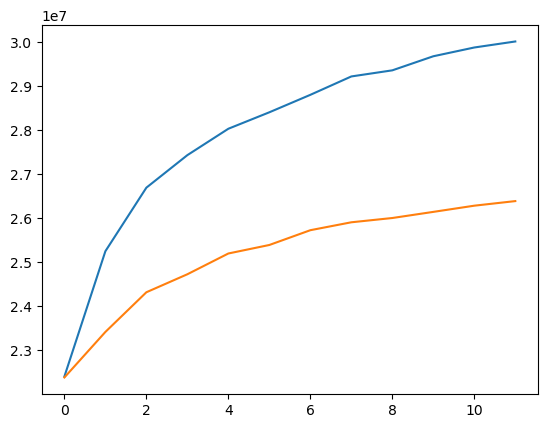

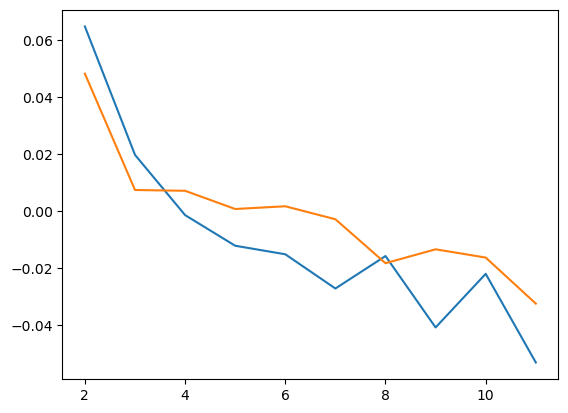

In [42]:
plt.figure()
plt.plot(range(len(models)),[model.lower_bound_ for model in models],label="Lognormal")
plt.plot(range(len(log_models)),[model.lower_bound_ for model in log_models],label="Normal")

plt.figure()
plt.plot(range(2,len(silhouette_scores)+1),silhouette_scores[1:],label="Lognormal")
plt.plot(range(2,len(log_silhouette_scores)+1),log_silhouette_scores[1:],label="Normal")